<a href="https://colab.research.google.com/github/ducluongtran9121/Poisoning-attack-FL-IDS/blob/master/IDS_ML_DDoS2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
#4/1AX4XfWj8H3I-bMAGyw0P2kqPjVx0I9rhhQKdQzgyra8YeOrcU7GmzIU2R1s

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import sys
import io
import random
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.model_selection import train_test_split


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/GAN-Research/DDoS2019/LDAP.csv")

dataset.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,...,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,13605,172.16.0.5-192.168.50.4-870-2908-17,172.16.0.5,870,192.168.50.4,2908,17,2018-11-03 10:09:00.565557,1,2,0,422.0,0.0,211.0,211.0,211.0,0.0,0.0,0.0,0.0,0.0,4.220000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0,0.0,316.5,211.0,0.0,-2,0,0,0,0,0,0,2,422,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
1,62631,172.16.0.5-192.168.50.4-871-53796-17,172.16.0.5,871,192.168.50.4,53796,17,2018-11-03 10:09:00.565559,48,2,0,530.0,0.0,265.0,265.0,265.0,0.0,0.0,0.0,0.0,0.0,1.104167e+07,4.166667e+04,48.0,0.0,48.0,48.0,48.0,48.0,0.0,48.0,48.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0,0.0,397.5,265.0,0.0,-2,0,0,0,0,0,0,2,530,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
2,143869,172.16.0.5-192.168.50.4-648-40660-17,172.16.0.5,648,192.168.50.4,40660,17,2018-11-03 10:09:00.565608,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,4.580000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,-2,0,0,0,0,0,0,2,458,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
3,16171,172.16.0.5-192.168.50.4-872-54308-17,172.16.0.5,872,192.168.50.4,54308,17,2018-11-03 10:09:00.565993,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,4.580000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,-2,0,0,0,0,0,0,2,458,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
4,80845,172.16.0.5-192.168.50.4-873-40653-17,172.16.0.5,873,192.168.50.4,40653,17,2018-11-03 10:09:00.565994,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,4.580000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,-2,0,0,0,0,0,0,2,458,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS


Label distribution Dataset:
LDAP       1905191
NetBIOS     202919
BENIGN        5124
Name:  Label, dtype: int64
---------------/----------------
LDAP       90.155231
NetBIOS     9.602297
BENIGN      0.242472
Name:  Label, dtype: float64


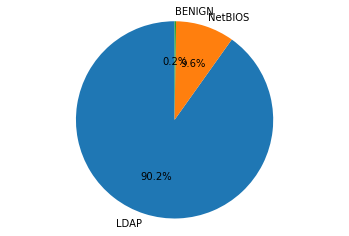

In [ ]:
print('Label distribution Dataset:')
print(dataset[' Label'].value_counts())

print('---------------/----------------')

print(dataset[' Label'].value_counts()/len(dataset)*100)

ratio = dataset[' Label'].value_counts()
labels = ratio.index[0], ratio.index[1], ratio.index[2]
sizes = [ratio.values[0], ratio.values[1], ratio.values[2]]

figure, axis = plt.subplots()
axis.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axis.axis('equal')

plt.show()

In [ ]:
# Create attack column, containing binary labels
dataset[' Label'] = np.where(dataset[' Label'] == 'BENIGN', 0, 1)

In [ ]:
print('Label distribution Dataset:')
print(dataset[' Label'].value_counts())

Label distribution Dataset:
1    2108110
0       5124
Name:  Label, dtype: int64


In [ ]:
# check if there are any Null values
print(dataset.isnull().any().any())
print(dataset.shape)

True
(2113234, 88)


In [ ]:
# Replace Inf values with NaN
dataset = dataset.replace([np.inf, -np.inf], np.nan)
# Drop all occurences of NaN
dataset = dataset.dropna()
# Double check these are all gone
print( dataset.isnull().any().any() )
print( dataset.shape )

False
(2059122, 88)


In [ ]:
attack = [' Label']
# xs=feature vectors, ys=labels
xs = dataset.drop(attack, axis=1)
ys = dataset[attack]

# split dataset - stratified
#x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3, random_state=1, stratify=ys[' Label'])
x_drop, x_new, y_drop, y_new = train_test_split(xs, ys, test_size=0.2, random_state=1, stratify=ys[' Label'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3, random_state=1, stratify=ys[' Label'])

In [ ]:
dataset.columns

Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [ ]:
column_names = np.array(list(x_train))
to_drop = []
for x in column_names:
    size = x_train.groupby([x]).size()
    # check for columns that only take one value
    if (len(size.unique()) == 1):
        to_drop.append(x)
to_drop.append('Flow ID')
to_drop.append(' Source IP')
to_drop.append(' Destination IP')
to_drop.append(' Timestamp')
to_drop.append('SimillarHTTP')
to_drop

[' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 'FIN Flag Count',
 ' PSH Flag Count',
 ' ECE Flag Count',
 'Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',
 ' Fwd Avg Bulk Rate',
 ' Bwd Avg Bytes/Bulk',
 ' Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate',
 'Flow ID',
 ' Source IP',
 ' Destination IP',
 ' Timestamp',
 'SimillarHTTP']

In [ ]:
x_train = x_train.drop(to_drop, axis=1)
x_test = x_test.drop(to_drop, axis=1)

In [ ]:
x_train.shape

(1441385, 70)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Normalise
min_max_scaler = MinMaxScaler().fit(x_train)

# Apply normalisation to dataset
x_train = min_max_scaler.transform(x_train)
x_test = min_max_scaler.transform(x_test)

# All values between 0 and 1
pd.Series(x_train.flatten()).describe()

count    1.008970e+08
mean     2.065519e-01
std      3.744396e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.333333e-01
max      1.000000e+00
dtype: float64

BINARY CLASSIFICATION

In [ ]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()

# fit the model
start = time.time()
classifier.fit(x_train, y_train[' Label'])
end = time.time()
training_time = end - start
print('Training time:',training_time)

Training time: 7.325384140014648


In [ ]:
# predict test
start = time.time()
y_predicted = classifier.predict(x_test)
end = time.time()
predict_time = end  - start
print('Prediction time:', predict_time)
confusion_svm = pd.crosstab(y_test[' Label'], y_predicted)
confusion_svm

Prediction time: 0.07541227340698242


col_0,0,1
Label,,
0,1505,11
1,17,616204


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test[' Label'], y_predicted)

d = {'Label': [0,1], 'Precision': precision, 'Recall' : recall, 'Fscore': fscore, 'Support': support}
results = pd.DataFrame(data=d)
results

,Label,Precision,Recall,Fscore,Support
0,0,0.988830,0.992744,0.990783,1516
1,1,0.999982,0.999972,0.999977,616221


In [ ]:
precision_svm, recall_svm, fscore_svm, n = score(y_test[' Label'], y_predicted, average='macro')

from sklearn.metrics import accuracy_score
accuracy_svm = accuracy_score(y_test[' Label'], y_predicted)

In [ ]:
print('Support Vector Machine: Precision / Recall / Fscore / Accuracy')
print('Binary Labels:', precision_svm, recall_svm, fscore_svm, accuracy_svm)

Support Vector Machine: Precision / Recall / Fscore / Accuracy
Binary Labels: 0.9944063176449702 0.9963582379097031 0.9953803454528847 0.9999546732671023
